# **LIMPIEZA DE DATOS**

### Notebook que explica el procedimiento seguido para la limpieza de los datos que se obtuvieron utilizando Web Scraping en páginas como Google Facts, Chequeado, CNN.

El resultado final es una primera versión del dataset final que se utilizará para la creación de nuestro modelo de aprendizaje automático

In [1097]:
# Instalación de modulo para eliminar símbolos en los textos 
!pip install unidecode

In [1098]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Google Facts

In [1099]:
data = 'https://raw.githubusercontent.com/christianvadillo/InfoVac/main/data/raw/google_facts_api.csv'
df_google = pd.read_csv(data)
df_google.head(3)

,url,reviewDate,textualRating,languageCode,publisher.name,publisher.site,title,text,claimant,claimDate
0,https://www.newtral.es/bulos-coronavirus-pcr-kary-mullis-videos/20201013/,2020-10-13T00:00:00Z,Falso,es,Newtral,newtral.es,NaN,"Estos vídeos de Kary Mullis, inventor del PCR, dejan muy claro que el test no sirve para detectar virus. Desmontan la herramienta que usan nuestro...",NaN,NaN
1,https://colombiacheck.com/chequeos/no-ecuador-no-encontro-la-cura-para-el-covid-19-ni-mando-al-carajo-la-oms,2020-10-08T18:36:17Z,Falso,es,ColombiaCheck,colombiacheck.com,"No, Ecuador no encontró la cura para el COVID-19 ni ‘mandó al carajo a la OMS’",Ecuador venció al coronavirus,NaN,NaN
2,https://www.telemundo.com/noticias/noticias-telemundo/elecciones-eeuu-2020/las-afirmaciones-falsas-y-enganosas-que-verificamos-durante-el-debate-e...,2020-10-08T00:00:00Z,Falso,es,Telemundo,telemundo.com,Las afirmaciones falsas y engañosas del debate entre Harris y Pence,"""Trump llamó al coronavirus un ""fraude"".",Kamala Harris,2020-10-07T00:00:00Z


In [1100]:
df_google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             1587 non-null   object
 1   reviewDate      1482 non-null   object
 2   textualRating   1587 non-null   object
 3   languageCode    1587 non-null   object
 4   publisher.name  1587 non-null   object
 5   publisher.site  1587 non-null   object
 6   title           1448 non-null   object
 7   text            1534 non-null   object
 8   claimant        764 non-null    object
 9   claimDate       877 non-null    object
dtypes: object(10)
memory usage: 124.1+ KB


In [1101]:
df_google = df_google.convert_dtypes()
df_google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             1587 non-null   string
 1   reviewDate      1482 non-null   string
 2   textualRating   1587 non-null   string
 3   languageCode    1587 non-null   string
 4   publisher.name  1587 non-null   string
 5   publisher.site  1587 non-null   string
 6   title           1448 non-null   string
 7   text            1534 non-null   string
 8   claimant        764 non-null    string
 9   claimDate       877 non-null    string
dtypes: string(10)
memory usage: 124.1 KB


Una primera revisión nos señala que hay datos faltantes. Además, todas las columnas son detectadas como 'string', pero se sabe que hay columnas con fechas.

## Duplicados?

In [1102]:
df_google['title'].value_counts()[:5]

Non, 96,3% des morts du Covid-19 en Italie ne sont pas "décédés d'autres pathologies"    8
Usar mascarillas no provoca falta de oxígeno                                             8
El coronavirus de Wuhan: epidemia mundial de bulos (XIV) | Newtral                       7
These are test kits made in South Korea, not a 'cure' for COVID-19                       6
COVID-19: epidemia mundial de bulos (XVI) | Newtral                                      6
Name: title, dtype: Int64

Con 'value_counts()' podemos ver que hay títulos o artículos repetidos en nuestro conjunto de datos. 

In [1103]:
# Eliminando duplicados
df_google.drop_duplicates('title', keep='first', inplace=True)

In [1104]:
# Verificando 
df_google['title'].value_counts()[:5]

AMLO sí dijo “hay que abrazarse”, pero antes de que la OMS declarara pandemia al nuevo coronavirus    1
El video con el maniquí muestra un simulacro de transporte de pacientes con covid-19 en España        1
El coronavirus COVID-19 no se cura con gárgaras de bicarbonato caliente, como dice supuesta médica    1
La revista Muy Interesante no predijo el COVID-19 en 2014                                             1
Ningún test de la COVID-19 para hacer en casa tiene garantías sanitarias                              1
Name: title, dtype: Int64

## Datos faltantes?

In [1105]:
df_google.isnull().sum() / len(df_google) * 100

url                0.000000
reviewDate         6.886228
textualRating      0.000000
languageCode       0.000000
publisher.name     0.000000
publisher.site     0.000000
title              0.099800
text               3.892216
claimant          50.199601
claimDate         44.710579
dtype: float64

Tenemos datos faltantes en un par de columnas. Para tratar con 'claimDate' que tiene un porcentaje alto de valores faltantes podemos:


1.   Realizar una busqueda manual de los artículos para extraer la fecha faltante
2.   Utilizar 'reviewDate' como alternativa a 'claimDate'



##Noticias no relacionadas?

Durante una primera exploración se observó que durante el proceso de Web Scraping se recolectaron noticias que no tienen relación con la temática de este proyecto. Por tanto, se requiere filtrar estas noticias fuera de contexto para no perjudicar al modelo final.

In [1106]:
from unidecode import unidecode

In [1107]:
# Rellenando titulos y textos faltantes para evitar errores
df_google['title'].fillna('no title', inplace=True)
df_google['text'].fillna('no text', inplace=True)

In [1108]:
  COVID_WORDS = ['covid', 'coronavirus', 'vacuna', 'virus',
           'pandemia', 'sars-cov', 'cuarentena', 'infectado',
           'salud', 'oms', 'hospital', 'medico', 'dioxido', 'cloro', 
           'termometro', 'infrarojo', 
           'asinto', 'pcr', 'mascar', 'tapaboca', 'cubreboca', 'oximetro',
           'respira', 'contagi', 'desinfecta', 'dieta']
  

In [1109]:
def out_of_context(row: pd.Series) -> bool:
  """ Función que dado un título y una descripción, devuelve
  un booleano indicando si está fuera de contexto o no lo está """

  title, text = row['title'], row['text']
  for w in COVID_WORDS:
    if ((w in unidecode(text).lower()) or (w in unidecode(title).lower())):
      return False
  return True


In [1110]:
# Creamos una nueva columna y aplicamos la función definida
df_google['out_of_context'] = df_google.apply(lambda row: out_of_context(row), axis=1)


In [1111]:
# Visualicemos las noticias fuera de contexto
for title in df_google[df_google['out_of_context']]['title']:
  print(title)

Esta concejal no dijo que los ancianos son un “lastre” ni es de Uruguay, sino de Canarias, España
El presidente de México no propuso un impuesto a mascotas, era una nota satírica
El falso mensaje sobre supermercados y esterilización de productos con el secador de pelo
Ni Felipe VI ni Pedro Sánchez copiaron un discurso de una novela, fue su autora la que se inspiró en un texto de 2017 del rey español
Los supermercados que abren a las 07h00 a mayores de 65 años están en Argentina, no en España
Fotos de grandes fiestas tecno para desinformar sobre la marcha negacionista de Berlín
No hay pruebas de que evitar cosas heladas y dulces prevenga ...


In [1112]:
df_google['out_of_context']

0       False
1       False
2       False
3       False
4       False
        ...  
1505    False
1526    False
1578    False
1581    False
1583    False
Name: out_of_context, Length: 1002, dtype: bool

In [1113]:
# Filtremos para descartar estas noticias
# 'out_of_context' está formado por booleanos indicando con 'True' si una fila
# está fuera de contexto. Para filtrar y dejar las filas que si tienen relación
# con el tema de COVID-19, podemos negar la columna, es decir, cada 'True' se
# haga 'False' y todo 'False' se vuelva 'True'. Utilizamos el símbolo '~' para
# realizar esta operación
df_google = df_google[~df_google['out_of_context']]

## Verificando la coherencia en 'reviewDate'

In [1114]:
df_google['reviewDate'][:5]

0    2020-10-13T00:00:00Z
1    2020-10-08T18:36:17Z
2    2020-10-08T00:00:00Z
3    2020-10-07T18:36:00Z
4    2020-10-07T00:00:00Z
Name: reviewDate, dtype: string

In [1115]:
len(df_google['reviewDate'][0])

20

Se observa que cada fecha tiene una longitud de 20 caracteres. Verifiquemos que no exista fechas mayor o menor a esta cantidad

In [1116]:
df_google[df_google['reviewDate'].apply(lambda x: len(str(x))<20)]

,url,reviewDate,textualRating,languageCode,publisher.name,publisher.site,title,text,claimant,claimDate,out_of_context
7,https://maldita.es/malditobulo/2020/10/06/no-ni-la-gripe-mata-mas-que-la-covid19-ni-el-coronavirus-se-ha-saltado-suecia-como-dice-este-video/,<NA>,Falso,es,Maldita.es,maldita.es,"No, ni el coronavirus 'se ha saltado' Suecia ni la gripe mata más que la COVID-19 como dice este vídeo",La gripe mata más que el coronavirus y la COVID-19 se ha saltado Suecia,Redes sociales,2020-09-21T00:00:00Z,False
17,https://maldita.es/malditobulo/2020/10/02/ecuador-cura-coronavirus-ministerio-salud-enfermedad-bacteria-5g/,<NA>,Falso,es,Maldita.es,maldita.es,"No, Ecuador no ha descubierto la cura del coronavirus ni el Ministerio de Salud ecuatoriano ha dicho que la causa de la enfermedad es una bacteria...",Ecuador ha descubierto la cura del coronavirus y el Ministerio de Salud ecuatoriano sostiene que la causa de la enfermedad es una bacteria amplifi...,Redes sociales,2020-07-22T00:00:00Z,False
23,https://maldita.es/malditobulo/2020/09/25/bill-gates-confirmado-implantar-chips-vacunas-covid-19/,<NA>,Falso,es,Maldita.es,maldita.es,"No, Bill Gates no ha confirmado que van a ""implantar chips"" en las vacunas de la COVID-19",Bill Gates confirma que van a implantar chips en las vacunas del SARS-CoV-2,Redes sociales,2020-10-02T00:00:00Z,False
27,https://maldita.es/malditobulo/2020/09/23/cuidado-con-este-video-difundido-como-si-nos-estuvieran-enganando-haciendo-pasar-un-maniqui-por-un-pacie...,<NA>,Falso,es,Maldita.es,maldita.es,Cuidado con este vídeo difundido como si estuvieran haciendo pasar un maniquí por un paciente con coronavirus: es una simulación realizada en un t...,Hacen pasar un maniquí por un paciente de coronavirus,Redes sociales,2020-08-31T00:00:00Z,False
28,https://maldita.es/malditobulo/2020/09/21/servicio-cardiovascular-hospital-virgen-macarena-sevilla-positivo-coronavirus/,<NA>,Falso,es,Maldita.es,maldita.es,"No, no es cierto que todo el servicio de Cardiología y Cirugía Cardiovascular del Hospital Virgen Macarena de Sevilla haya dado positivo en corona...",En el Hospital Virgen Macarena de Sevilla el servicio de cardiovascular entero ha dado positivo por coronavirus junto a varios enfermeros de urgen...,Redes sociales,2020-09-21T00:00:00Z,False
...,...,...,...,...,...,...,...,...,...,...,...
1004,https://maldita.es/malditatecnologia/2020/06/24/cadena-google-una-app-covid-secretamente-actualizacion-rastreo-contactos/,<NA>,Falso,es,Maldita.es,maldita.es,La cadena de WhatsApp que dice que Google está instalando una app de COVID secretamente: es una actualización para que funcionen las apps de rastr...,El banano bloquea la entrada del COVID-19 al cuerpo humano,Varias fuentes,2020-05-05T00:00:00Z,False
1017,https://maldita.es/malditobulo/2020/06/19/video-torre-eiffel-espectaculo-luces-homenaje-victimas-covid-19/,<NA>,Falso,es,Maldita.es,maldita.es,"No, este vídeo de un espectáculo de luces en la Torre Eiffel no es actual ni es un homenaje a las víctimas de la COVID-19: es de 2019 por el 130º ...",Organización Mundial de la Salud lanzó una advertencia sobre el virus Nipah “más mortal que la COVID-19”,Redes sociales,2020-06-17T20:25:02Z,False
1034,https://maldita.es/malditobulo/2020/06/11/huye-hospital-covid-19-curen-mano/,<NA>,Falso,es,Maldita.es,maldita.es,"No, esta persona no huye del hospital porque lo van a ingresar por COVID-19 tras ir a que le curen una mano: son imágenes de 2019 de un presunto r...",El 5G está relacionado con el coronavirus,<NA>,<NA>,False
1039,https://maldita.es/malditobulo/2020/06/09/cura-bebida-jengibre-limon-aspirina-canela-miel-ajo-cebolla-coronavirus/,<NA>,Falso,es,Maldita.es,maldita.es,"No, la COVID-19 no se cura con una bebida de jengibre, limón, aspirina, canela, miel, ajo y cebolla: ninguna bebida cura o previene el coronavirus",Ningún ministro de Podemos asiste al minuto de silencio en Moncloa por los muertos por COVID-19,Varias fuentes,2020-05-27T00:00:00Z,False


In [1117]:
df_google[df_google['reviewDate'].apply(lambda x: len(str(x))>20)]

,url,reviewDate,textualRating,languageCode,publisher.name,publisher.site,title,text,claimant,claimDate,out_of_context


Observamos que, en general, la columna es consistente. También se obervan datos faltantes.

In [1118]:
# Extrayendo las filas en el que 'reviewDate' tiene NaN
rows_missing_date = df_google['reviewDate'].isnull()

In [1119]:
for u in df_google[rows_missing_date]['url']:
  print(u)

https://maldita.es/malditobulo/2020/10/06/no-ni-la-gripe-mata-mas-que-la-covid19-ni-el-coronavirus-se-ha-saltado-suecia-como-dice-este-video/
https://maldita.es/malditobulo/2020/10/02/ecuador-cura-coronavirus-ministerio-salud-enfermedad-bacteria-5g/
https://maldita.es/malditobulo/2020/09/25/bill-gates-confirmado-implantar-chips-vacunas-covid-19/
https://maldita.es/malditobulo/2020/09/23/cuidado-con-este-video-difundido-como-si-nos-estuvieran-enganando-haciendo-pasar-un-maniqui-por-un-paciente-con-coronavirus-es-una-simulacion-realizada-en-un-tren-medicalizado/
https://maldita.es/malditobulo/2020/09/21/servicio-cardiovascular-hospital-virgen-macarena-sevilla-positivo-coronavirus/
https://maldita.es/malditobulo/2020/09/21/juegos-olimpicos-londres-2012-predijo-coronavirus-feretros/
https://maldita.es/malditobulo/2020/09/21/coronavirus-revista-muy-interesante-2014-actual/
https://maldita.es/malditobulo/2020/09/19/foto-colegio-padres-distancia-seguridad-rumania/
https://maldita.es/malditobu

Otro punto que se observó es que todos los registros faltantes provienen del mismo dominio (maldita.es). Exceptuando: 

>` https://maldita.es/malditobulo/no-susan-george-no-ha-dicho-que-los-espanoles-son-como-ratas-de-laboratorio-en-relacion-a-la-crisis-del-coronavirus-la-frase-sale-de-una-entrevista-realizada-en-2012`





 Además, es posible obtener las fechas faltantes usando información de la columna 'url'.

> `https://maldita.es/malditobulo/2020/06/09/....'`

Para esto, dividimos el string de la url utilizando como referencia el símbolo '/' y extraemos el año, mes y día mediante las posiciones correspondientes

In [1120]:
'https://maldita.es/malditobulo/2020/06/11/huye-hospital-covid-19-curen-mano/'.split('/')

['https:',
 '',
 'maldita.es',
 'malditobulo',
 '2020',
 '06',
 '11',
 'huye-hospital-covid-19-curen-mano',
 '']

In [1121]:
def extract_date_from_url(url: str) -> str:
  """ Función que extrae una fecha dado una url del dominio
  maldita.es/malditobulo/2020 """
  splited_text = url.split('/')
  if len(splited_text) > 5:
    return '/'.join(splited_text[4:7])
  return ' '
  

In [1122]:
# Aplicamos la función en las filas con valores nulos de la columna 'reviewDate'
df_google.loc[rows_missing_date, 'reviewDate'] = df_google[rows_missing_date]['url'].apply(extract_date_from_url)

In [1123]:
# Verificamos el resultado
df_google[rows_missing_date]

,url,reviewDate,textualRating,languageCode,publisher.name,publisher.site,title,text,claimant,claimDate,out_of_context
7,https://maldita.es/malditobulo/2020/10/06/no-ni-la-gripe-mata-mas-que-la-covid19-ni-el-coronavirus-se-ha-saltado-suecia-como-dice-este-video/,2020/10/06,Falso,es,Maldita.es,maldita.es,"No, ni el coronavirus 'se ha saltado' Suecia ni la gripe mata más que la COVID-19 como dice este vídeo",La gripe mata más que el coronavirus y la COVID-19 se ha saltado Suecia,Redes sociales,2020-09-21T00:00:00Z,False
17,https://maldita.es/malditobulo/2020/10/02/ecuador-cura-coronavirus-ministerio-salud-enfermedad-bacteria-5g/,2020/10/02,Falso,es,Maldita.es,maldita.es,"No, Ecuador no ha descubierto la cura del coronavirus ni el Ministerio de Salud ecuatoriano ha dicho que la causa de la enfermedad es una bacteria...",Ecuador ha descubierto la cura del coronavirus y el Ministerio de Salud ecuatoriano sostiene que la causa de la enfermedad es una bacteria amplifi...,Redes sociales,2020-07-22T00:00:00Z,False
23,https://maldita.es/malditobulo/2020/09/25/bill-gates-confirmado-implantar-chips-vacunas-covid-19/,2020/09/25,Falso,es,Maldita.es,maldita.es,"No, Bill Gates no ha confirmado que van a ""implantar chips"" en las vacunas de la COVID-19",Bill Gates confirma que van a implantar chips en las vacunas del SARS-CoV-2,Redes sociales,2020-10-02T00:00:00Z,False
27,https://maldita.es/malditobulo/2020/09/23/cuidado-con-este-video-difundido-como-si-nos-estuvieran-enganando-haciendo-pasar-un-maniqui-por-un-pacie...,2020/09/23,Falso,es,Maldita.es,maldita.es,Cuidado con este vídeo difundido como si estuvieran haciendo pasar un maniquí por un paciente con coronavirus: es una simulación realizada en un t...,Hacen pasar un maniquí por un paciente de coronavirus,Redes sociales,2020-08-31T00:00:00Z,False
28,https://maldita.es/malditobulo/2020/09/21/servicio-cardiovascular-hospital-virgen-macarena-sevilla-positivo-coronavirus/,2020/09/21,Falso,es,Maldita.es,maldita.es,"No, no es cierto que todo el servicio de Cardiología y Cirugía Cardiovascular del Hospital Virgen Macarena de Sevilla haya dado positivo en corona...",En el Hospital Virgen Macarena de Sevilla el servicio de cardiovascular entero ha dado positivo por coronavirus junto a varios enfermeros de urgen...,Redes sociales,2020-09-21T00:00:00Z,False
...,...,...,...,...,...,...,...,...,...,...,...
1004,https://maldita.es/malditatecnologia/2020/06/24/cadena-google-una-app-covid-secretamente-actualizacion-rastreo-contactos/,2020/06/24,Falso,es,Maldita.es,maldita.es,La cadena de WhatsApp que dice que Google está instalando una app de COVID secretamente: es una actualización para que funcionen las apps de rastr...,El banano bloquea la entrada del COVID-19 al cuerpo humano,Varias fuentes,2020-05-05T00:00:00Z,False
1017,https://maldita.es/malditobulo/2020/06/19/video-torre-eiffel-espectaculo-luces-homenaje-victimas-covid-19/,2020/06/19,Falso,es,Maldita.es,maldita.es,"No, este vídeo de un espectáculo de luces en la Torre Eiffel no es actual ni es un homenaje a las víctimas de la COVID-19: es de 2019 por el 130º ...",Organización Mundial de la Salud lanzó una advertencia sobre el virus Nipah “más mortal que la COVID-19”,Redes sociales,2020-06-17T20:25:02Z,False
1034,https://maldita.es/malditobulo/2020/06/11/huye-hospital-covid-19-curen-mano/,2020/06/11,Falso,es,Maldita.es,maldita.es,"No, esta persona no huye del hospital porque lo van a ingresar por COVID-19 tras ir a que le curen una mano: son imágenes de 2019 de un presunto r...",El 5G está relacionado con el coronavirus,<NA>,<NA>,False
1039,https://maldita.es/malditobulo/2020/06/09/cura-bebida-jengibre-limon-aspirina-canela-miel-ajo-cebolla-coronavirus/,2020/06/09,Falso,es,Maldita.es,maldita.es,"No, la COVID-19 no se cura con una bebida de jengibre, limón, aspirina, canela, miel, ajo y cebolla: ninguna bebida cura o previene el coronavirus",Ningún ministro de Podemos asiste al minuto de silencio en Moncloa por los muertos por COVID-19,Varias fuent

In [1124]:
df_google[df_google['reviewDate'].apply(lambda x: len(str(x))<10)]

,url,reviewDate,textualRating,languageCode,publisher.name,publisher.site,title,text,claimant,claimDate,out_of_context
104,https://maldita.es/malditobulo/no-susan-george-no-ha-dicho-que-los-espanoles-son-como-ratas-de-laboratorio-en-relacion-a-la-crisis-del-coronavirus...,,Falso,es,Maldita.es,maldita.es,"No, Susan George no ha dicho que 'los españoles son como ratas de laboratorio' en relación a la crisis del coronavirus: la frase sale de una entre...",Inhalar eucalipto previene y elimina el nuevo coronavirus,<NA>,2020-07-07T00:00:00Z,False


Agregamos manualmente la fecha del artículo restante

In [1125]:
df_google.loc[104, 'reviewDate'] = '2020/07/22'

Transformemos la columna 'reviewDate' de string a un tipo 'datetime' y visualicemos el rango de valores.

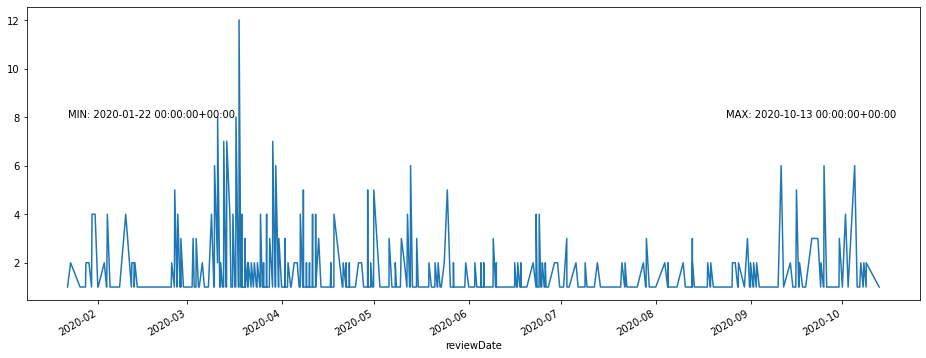

In [1126]:
# Convert to datetime
df_google['reviewDate'] = pd.to_datetime(df_google['reviewDate'], yearfirst=True, utc=True)
# Group by reviewDate for the visualization
df_google.groupby('reviewDate').count()['title'].plot(figsize=(16, 6))
plt.text(x=df_google['reviewDate'].min(), 
         y=8, s=f"MIN: {df_google['reviewDate'].min()}", rotation=0);
plt.text(x=df_google['reviewDate'].max()-np.timedelta64(50, 'D'), 
         y=8, s=f"MAX: {df_google['reviewDate'].max()}", rotation=0);

El rango es acorde a las fechas de inicio y actual

# Chequeado
Se realizó un procedimiendo similar al descrito en la sección previa

In [1127]:
data = 'https://raw.githubusercontent.com/christianvadillo/InfoVac/main/data/raw/chequeado_articles.csv'
df_cheq = pd.read_csv(data, na_values=' ')
df_cheq

,pais,titulo,calificacion,descripcion,fecha del chequeo,organizacion,link al chequeo,tipo de informacion,formato de la desinformacion,tipo de nota,link a la desinformacion,fecha deteccion desinformacion,origen,persona,actualizaciones,circulo en otros paises,extra
0,Argentina,Confirmado un caso de Coronavirus en Santiago del Estero,Falso,El Ministerio de Salud de la provincia afirmó que se trataba de una desinformación.,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/no-no-se-confirmo-un-caso-de-coronavirus-en-santiago-del-estero/,Situación de un país,Imagen,Desinformación viral,https://drive.google.com/file/d/18MViCcWRoVVVgzBOSmdBiV4FNYIRzT0M/view,26/02/2020,Facebook,Desconocido,NaN,\n,NaN
1,Argentina,Confirmado un caso de Coronavirus en Chaco.,Falso,El Ministerio de Salud de la provincia afirmó que se trataba de una desinformación.,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/es-falso-que-se-confirmo-un-caso-de-coronavirus-en-chaco/,Situación de un país,Imagen,Desinformación viral,https://drive.google.com/file/d/1SJ2-A3WCr-vodR1jwoJz5wEfIOo2-70T/view,NaN,Facebook,Desconocido,NaN,\n,NaN
2,Argentina,Un médico argentino descubrió y está aplicando una vacuna contra el coronavirus en España.,Falso,La OMS informa que hasta el momento no existe una vacuna o medicamento antiviral específico para prevenir o tratar el Coronavirus,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/es-falso-que-un-medico-argentino-descubrio-y-esta-aplicando-una-vacuna-contra-el-coronavirus-en-espana/,Curas,"Imagen, Texto",Desinformación viral,https://drive.google.com/file/d/1FYpMz5CN3ZyySHa8w8wQsea6ap_Bq2Mc/view,NaN,"Redes sociales, Whatsapp",Desconocido,NaN,España \n,NaN
3,Argentina,"Presidente de Argentina, Alberto Fernández: “La OMS recomienda que uno tome muchas bebidas calientes porque el calor mata al virus”.",Falso,La OMS no emitió ninguna recomendación sobre el consumo de bebidas para la prevención del Coronavirus y especialistas hasta dicen que podría llega...,12/03/2020,Chequeado,https://chequeado.com/ultimas-noticias/alberto-fernandez-la-organizacion-mundial-de-la-salud-entre-las-cosas-que-recomienda-es-que-uno-tome-muchas...,Curas,Audio,Chequeo a figuras públicas,NaN,12/03/2020,Otros,Alberto Fernández (presidente de Argentina),NaN,"España, Hong Kong, Colombia \n",NaN
4,Argentina,"El presidente de Argentina, Alberto Fernández, dijo que el coronavirus muere a los 26° C en el ambiente.",Insostenible,Todavía no hay un consenso científico sobre el impacto de la temperatura ambiente en este virus en particular.,12/03/2020,Chequeado,https://chequeado.com/ultimas-noticias/alberto-fernandez-dijo-que-el-coronavirus-muere-a-los-26-c-pero-no-hay-pruebas-de-eso/,Características del virus,Audio,Chequeo a figuras públicas,NaN,12/03/2020,Otros,Alberto Fernández (presidente de Argentina),NaN,México \n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,España,"El chalet de Aravaca (Madrid, España) que desalojó la Policía Nacional por una fiesta con 200 personas es del ex presidente español José Luis Rodr...",Falso,"El ex presidente español Zapatero no es el propietario, su casa está en otro lugar y la policía lo negó.",05/10/2020,Maldita.es,https://maldita.es/malditobulo/2020/10/05/fiesta-aravaca-200-personas-chalet-zapatero-psoe-desalojada-policia-nacional-madrid/,Otros,Texto,Desinformación viral,https://maldita.es/app/uploads/2020/10/BULO.jpg,NaN,"Facebook, Twitter",Desconocido,NaN,\n,NaN
3062,España,Una imagen de teléfonos descolgados en un centro sanitario en España,Falso,"No es España, es Polonia. En la foto aparece el logo de un Health Fond en Polonia.",05/10/2020,Maldita.es,https://maldita.es/malditobulo/2020/10/05/telefonos-descolgados-centro-sanitario/,Otros,Imagen,Desinformación viral,https://maldita.es/app/uploads/2020/10/BULO-no-cogen-tel%C3%A9fono-centro-salud.jpg,NaN,Twitter,Desconocido,NaN,\n,NaN
3063,España,The Lancet ha negado la existencia de la COVID-19 y se ha vuelto conspiracionis

In [1128]:
df_cheq = df_cheq.convert_dtypes()

## Duplicados? 

In [1129]:
df_cheq['descripcion'].duplicated().sum()

25

In [1130]:
df_cheq.drop_duplicates('descripcion', keep='first', inplace=True)

In [1131]:
df_cheq['descripcion'].duplicated().sum()

0

## Datos faltantes?

In [1132]:
df_cheq.isnull().sum() / len(df_cheq) * 100

pais                               0.000000
titulo                             0.000000
calificacion                      19.960539
descripcion                        0.032884
fecha del chequeo                  0.098652
organizacion                       0.000000
link al chequeo                    0.000000
tipo de informacion                0.000000
formato de la desinformacion      18.151924
tipo de nota                       0.131536
link a la desinformacion          71.029267
fecha deteccion desinformacion    92.338047
origen                            18.941138
persona                           19.072673
actualizaciones                   98.914831
circulo en otros paises            0.230187
extra                             99.802696
dtype: float64

Encontramos que hay columnas con muchos valores faltantes. Analicemos primero la columna 'calificación'

In [1133]:
df_cheq[df_cheq['calificacion'].isnull()]

,pais,titulo,calificacion,descripcion,fecha del chequeo,organizacion,link al chequeo,tipo de informacion,formato de la desinformacion,tipo de nota,link a la desinformacion,fecha deteccion desinformacion,origen,persona,actualizaciones,circulo en otros paises,extra
107,España,"Una sanitaria habla de pacientes jóvenes, sin patología, que van a morir por coronavirus en la Fundación Jiménez Díaz",<NA>,El jefe de la UCI de la Fundación Jiménez Díaz ha afirmado en una circular interna que es falso que los jóvenes tengan ninguna patología asociada ...,12/03/2020,Maldita.es,https://maldita.es/malditobulo/2020/03/16/coronavirus-jovenes-jimenez-diaz-se-van-a-morir-whatsapp/,Situación de un país,Audio,Explicador,<NA>,<NA>,Whatsapp,Desconocido,<NA>,,<NA>
111,España,El coronavirus y el calor: ¿COVID-19 desaparecerá por las temperaturas altas?,<NA>,"Cuando se publicó esta verificación, aún no había evidencia científica suficiente para demostrar que el virus podría desaparecer con altas tempera...",28/02/2020,Maldita.es,https://maldita.es/malditaciencia/2020/03/25/coronavirus-calor-temperatura/,Curas,Otro,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
112,España,Cartas y paquetes enviados de China podrían transmitir el virus.,<NA>,"Según la OMS, los coronavirus no sobreviven mucho tiempo en objetos, como las cartas o los paquetes.",26/02/2020,Maldita.es,https://maldita.es/malditaciencia/2020/03/26/coronavirus-vivos-superficies-proteccion-infeccion/,Características del virus,Otro,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
113,España,Cuándo deben usarse mascarillas con el coronavirus Covid-19.,<NA>,"Salvo excepciones, las mascarillas no están entre las medidas de protección y prevención que recomienda el Ministerio de Sanidad y la Organización...",26/02/2020,Maldita.es,https://maldita.es/malditaciencia/2020/03/11/mascarillas-coronavirus-proteccion/,Prevención,Otro,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
115,España,¿Qué sabemos sobre la sopa de murciélago y su relación con el origen del coronavirus?,<NA>,"Aunque los murciélagos sí pueden ser conductores del coronavirus, no estaba confirmado en el momento de la verificación que la pandemia se haya or...",30/01/2020,Maldita.es,https://maldita.es/malditaciencia/2020/01/30/que-sabemos-sobre-la-sopa-de-murcielago-y-su-relacion-con-el-origen-del-coronavirus/,Origen del virus,Video,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,España,Qué dice la evidencia científica sobre el cierre de parques y jardines para evitar contagios,<NA>,"Ha vuelto a pasar: muchos parques han cerrado y muchos otros lo harán si se aprueba el borrador de la propuesta que el ministro de Sanidad, Salvad...",30/09/2020,Maldita.es,https://maldita.es/malditaciencia/2020/10/05/cerrar-parques-no-medida-prioritaria-evidencias-cientificas/,Contagios,<NA>,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
3026,España,Por qué no hace falta quitarse la mascarilla periódicamente para tomar oxígeno ni para ventilar el rostro,<NA>,"En las últimas semanas, diferentes medios se han referido a si es recomendable realizar descansos periódicos cuando se usa la mascarilla para pode...",05/10/2020,Maldita.es,https://maldita.es/malditaciencia/2020/10/05/quitarse-mascarilla-periodicamente-no-tomar-oxigeno-ventilar-rostro/,Prevención,<NA>,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
3027,España,¿Cómo varió la valoración de Jair Bolsonaro y de Boris Johnson tras dar positivo en COVID-19?,<NA>,El presidente de Estados Unidos Donald Trump ha dado positivo en COVID-19. Pero no es el primer líder mundial en ser infectado por el coronavirus ...,02/10/2020,Maldita.es,https://maldita.es/maldita-te-explica/2020/10/02/efecto-coronavirus-covid-encuestas-valoracion-trump-bolsonaro-johnson/,Contagios,<NA>,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
3034,Argentina,"Muertes por coronavirus: la Argentina se ubica en el puesto 19 y no primera, como tituló Infobae",<NA>,Circuló en redes un tuit del portal Infobae en 

Notamos que el tipo de nota es el de 'Explicador'. Asumiremos que contiene información 'confiable' 

In [1134]:
df_cheq['calificacion'].fillna('confiable', inplace=True)

Explorando se encontró inconcistencias en algunos registros. Por ejemplo, el 3052 tiene información mal asignada.

In [1135]:
df_cheq.loc[3052]

pais                                                                                                                                                                          Colombia 
titulo                                                                                                                        En Filadelfia en 1918 hubo protestas contra la cuarentena
calificacion                                                                                                                                                                  confiable
descripcion                                                                                                                                                               Cuestionable 
fecha del chequeo                 Una centenaria foto circula en redes sociales asegurando que fue tomada en una protesta contra las medidas de confinamiento por causa de la gripe ...
organizacion                                                                    

Re asignemos en el orden correcto

In [1136]:
df_cheq.loc[3052, 'calificacion'] = df_cheq.loc[3052, 'descripcion']
df_cheq.loc[3052, 'descripcion'] = df_cheq.loc[3052, 'fecha del chequeo']
df_cheq.loc[3052, 'link a la desinformacion'] = df_cheq.loc[3052, 'fecha deteccion desinformacion']
df_cheq.loc[3052, 'fecha del chequeo'] = df_cheq.loc[3052, 'organizacion']

In [1137]:
df_cheq.loc[3052]

pais                                                                                                                                                                          Colombia 
titulo                                                                                                                        En Filadelfia en 1918 hubo protestas contra la cuarentena
calificacion                                                                                                                                                              Cuestionable 
descripcion                       Una centenaria foto circula en redes sociales asegurando que fue tomada en una protesta contra las medidas de confinamiento por causa de la gripe ...
fecha del chequeo                                                                                                                                                           28/08/2020 
organizacion                                                                    

Verifiquemos que no exista otro registro mal asignado

In [1138]:
df_cheq[df_cheq['descripcion'].apply(lambda x: len(x) if pd.notnull(x) else x) < 15]

,pais,titulo,calificacion,descripcion,fecha del chequeo,organizacion,link al chequeo,tipo de informacion,formato de la desinformacion,tipo de nota,link a la desinformacion,fecha deteccion desinformacion,origen,persona,actualizaciones,circulo en otros paises,extra
1314,Uruguay,Una pareja australiana a bordo del crucero en cuarentena por coronavirus recibió vino con un dron,confiable,Engañoso,La pareja -asombrada de que nadie confirmara la información con ellos- contó a una radio australiana que sus publicaciones sobre la entrega del vi...,19/02/2020,AFP,https://factual.afp.com/la-pareja-australiana-bordo-del-crucero-en-cuarentena-por-coronavirus-no-recibio-vino-con-un-dron,Otros,Imagen,Desinformación viral,https://factual.afp.com/sites/default/files/styles/list_xl/public/medias/factchecking/uruguay/coronavirus_vino_drone_1.jpg?itok=YWZfsx9c,<NA>,"Redes sociales, Medios",Foto publicada en Facebook por la pareja,<NA>,Australia


In [1139]:
df_cheq.loc[1314, 'calificacion'] = df_cheq.loc[1314, 'descripcion']
df_cheq.loc[1314, 'descripcion'] = df_cheq.loc[1314, 'fecha del chequeo']
df_cheq.loc[1314, 'link a la desinformacion'] = df_cheq.loc[1314, 'fecha deteccion desinformacion']
df_cheq.loc[1314, 'fecha del chequeo'] = df_cheq.loc[1314, 'organizacion']

In [1140]:
df_cheq[df_cheq['descripcion'].apply(lambda x: len(x) if pd.notnull(x) else x) < 15]

,pais,titulo,calificacion,descripcion,fecha del chequeo,organizacion,link al chequeo,tipo de informacion,formato de la desinformacion,tipo de nota,link a la desinformacion,fecha deteccion desinformacion,origen,persona,actualizaciones,circulo en otros paises,extra


## Verificando la coherencia en 'fecha del chequeo'
Dado que 'fecha deteccion desinformacion' tiene un aproximado de 90% de datos faltantes, tomemos la columna 'fecha del chequeo' como la columna principal para la fecha.

In [1141]:
df_cheq.isnull().sum() / len(df_cheq) *100

pais                               0.000000
titulo                             0.000000
calificacion                       0.000000
descripcion                        0.032884
fecha del chequeo                  0.098652
organizacion                       0.000000
link al chequeo                    0.000000
tipo de informacion                0.000000
formato de la desinformacion      18.151924
tipo de nota                       0.131536
link a la desinformacion          71.029267
fecha deteccion desinformacion    92.338047
origen                            18.941138
persona                           19.072673
actualizaciones                   98.914831
circulo en otros paises            0.230187
extra                             99.802696
dtype: float64

In [1142]:
df_cheq['fecha del chequeo']

0       27/02/2020 
2       27/02/2020 
3       12/03/2020 
4       12/03/2020 
5       04/03/2020 
           ...     
3061    05/10/2020 
3062    05/10/2020 
3063    05/10/2020 
3064    05/10/2020 
3065    06/10/2020 
Name: fecha del chequeo, Length: 3041, dtype: string

In [1143]:
df_cheq[df_cheq['fecha del chequeo'].apply(lambda x: len(str(x))<11)]

,pais,titulo,calificacion,descripcion,fecha del chequeo,organizacion,link al chequeo,tipo de informacion,formato de la desinformacion,tipo de nota,link a la desinformacion,fecha deteccion desinformacion,origen,persona,actualizaciones,circulo en otros paises,extra
130,España,Una otorrinolaringóloga ha recomendado tomar una tableta de vitamina C y omega de la marca GNC para fortalecer el sistema inmunológico y hacer fre...,Bulo,Ningún alimento previene de la infección por coronavirus,12/2/2020,Maldita.es,https://maldita.es/malditobulo/2020/02/27/vitamina-c-omega-coronavirus/,Prevención,Texto,Desinformación viral,<NA>,<NA>,Whatsapp,Desconocido,<NA>,,<NA>
1364,Argentina,Murió en el Hospital Muñíz un médico llamado “Marcos Vargas” por atender pacientes con COVID-19,Falso,"Desde el hospital confirmaron a Chequeado que no hay ningún médico con ese nombre ni otro que haya fallecido por COVID-19. Además, la imagen que u...",<NA>,12/05/2020,Chequeado,https://chequeado.com/verificacionfb/no-no-murio-en-el-hospital-muniz-un-medico-llamado-marcos-vargas-por-atender-pacientes-con-covid-19/,Otros,Imagen,Desinformación viral,https://drive.google.com/file/d/10o4lD6OyRMLai3QwyAqfRpJOw7y20Gck/view?usp=sharing,<NA>,Facebook,Desconocido,<NA>,España
1457,Chile,"“El coronavirus no nos puede dar a nosotros, porque no somos chinos”, habría dicho Karen Longaric, canciller de Bolivia, según un supuesto titular...",Falso,El titular del periódico sobre el coronavirus es un fotomontaje,<NA>,09/03/2020,AFP,https://factual.afp.com/el-titular-de-un-diario-con-una-frase-de-la-canciller-boliviana-sobre-el-coronavirus-es-un-montaje,Otros,"Imagen, Texto",Desinformación viral,https://factual.afp.com/sites/default/files/styles/list_xl/public/medias/factchecking/chile_-_bolivia_-_peru/tachado_longaric.jpg?itok=2_zzLZN4,<NA>,Facebook,Desconocido,<NA>,
2221,Brasil,Un video en el que un policía de San Pablo cuenta que rescató a la madre viva de una “bolsa para cadáveres”,Falso,El video muestra a un oficial de policía en Amazonas que invadió un hospital porque pensó que su madre estaba a punto de ser enterrada viva. Vio u...,<NA>,23/06/2020,Agência Lupa,https://piaui.folha.uol.com.br/lupa/2020/06/23/latamchequea-policia-rescato-madre-viva/,Otros,Video,Desinformación viral,<NA>,<NA>,Facebook,Desconocido,<NA>,
2792,Venezuela,Douglas León Natera: “25 % de los fallecidos por COVID-19 en Venezuela pertenece al sector salud”,Verdad,El gremio y las organizaciones no gubernamentales vinculadas al sector salud muestran con cifras la alta incidencia de muertes de quienes están en...,12/082020,Cotejo.info,https://cotejo.info/2020/08/leon-natera-fallecidos-covid-19-vzla-sector-salud/,Situación de un país,<NA>,Chequeo a figuras públicas,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>


In [1144]:
# Rellenando valores <NA> usando la columna organizacion
df_cheq['fecha del chequeo'].fillna(df_cheq['organizacion'], inplace=True)

In [1145]:
df_cheq[df_cheq['fecha del chequeo'].apply(lambda x: len(str(x))>11)]

,pais,titulo,calificacion,descripcion,fecha del chequeo,organizacion,link al chequeo,tipo de informacion,formato de la desinformacion,tipo de nota,link a la desinformacion,fecha deteccion desinformacion,origen,persona,actualizaciones,circulo en otros paises,extra
1272,Guatemala,El uso prolongado de la mascarilla produce hipoxia,Bulo,Se desmiente que el uso prolongado de las mascarillas produzca condiciones respiratorias como la hipoxia,05//05/2020,Agencia Ocote,https://www.agenciaocote.com/bulo-el-uso-prolongado-de-la-mascarilla-produce-hipoxia/,Prevención,Texto,Desinformación viral,<NA>,04/05/2020,"Whatsapp, Facebook",Desconocido,<NA>,"México, España",<NA>
1273,Guatemala,"A.Giammattei, presidente de Guatemala: Fase de contención exitosa...estamos en una curva que no llega a los 45 grados",Engañoso,Se verifica la afirmación del presidente de Guatemala en la que dice que la curva contagios no llega a los 45 grados. Una infectóloga y un epidemi...,06//05/2020,Agencia Ocote,https://www.agenciaocote.com/a-giammattei-fase-de-contencion-exitosa-estamos-en-una-curva-que-no-llega-los-45-grados/,Situación de un país,Texto,Chequeo a figuras públicas,<NA>,30/04/2020,Otros,Alejandro Giammattei (presidente de Guatemala),<NA>,,<NA>
2217,Brasil,"El gobernador de San Pablo, João Doria (PSDB), manifestó que firmó un convenio para producir y testear una vacuna china contra la COVID-19 en agos...",Falso,"El texto se basa en la interpretación errónea de una afirmación del gobernador de San Pablo, João Doria. En una rueda de prensa el pasado jueves (...",22/06//2020,Agência Lupa,https://piaui.folha.uol.com.br/lupa/2020/06/22/latamchequea-doria-convenio-vacuna-covid-19/,Curas,Texto,Desinformación viral,<NA>,<NA>,Redes sociales,Desconocido,<NA>,,<NA>


In [1146]:
# Convertir los strings a tipo 'datetime'
df_cheq['fecha del chequeo'] = pd.to_datetime(df_cheq['fecha del chequeo'],
                                              dayfirst=True, errors='coerce')

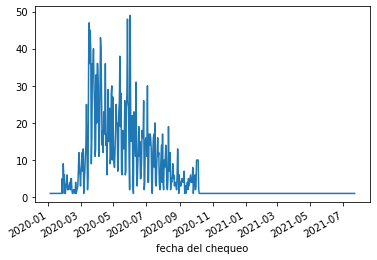

In [1147]:
df_cheq.groupby('fecha del chequeo').count()['pais'].plot()

La gráfica nos muestra la presencia de outliers, específicamente fechas que no tienen sentido

In [1148]:
df_cheq[df_cheq['fecha del chequeo'] > pd.to_datetime('2020/10/10')]

,pais,titulo,calificacion,descripcion,fecha del chequeo,organizacion,link al chequeo,tipo de informacion,formato de la desinformacion,tipo de nota,link a la desinformacion,fecha deteccion desinformacion,origen,persona,actualizaciones,circulo en otros paises,extra
1345,Ecuador,La metástasis de la corrupción,confiable,La crisis sanitaria por el coronavirus ha desatado una ola de corrupción en hospitales en Ecuador. ¿Qué sucede dentro de los instituciones de salud?,2020-11-05,GK Ecuador,https://gk.city/2020/05/10/corrupcion-hospitales-ecuador/,Situación de un país,<NA>,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
1346,Ecuador,La doble lucha por sobrevivir,confiable,Muchos pacientes oncológicos han tenido que esperar varias semanas para continuar con sus tratamientos mientras su vida pende de un hilo. ¿Cómo es...,2020-11-06,GK Ecuador,https://gk.city/2020/05/10/pacientes-cancer-coronavirus/,Otros,<NA>,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
1347,Ecuador,"No, el dióxido de cloro diluido en agua no cura el covid-19",confiable,Algunos testimonios de gente infectada con el nuevo coronavirus que dice haber mejorado tras tomar una solución de dióxido de cloro. ¿Cómo afecta ...,2020-11-07,GK Ecuador,https://gk.city/2020/05/10/dioxido-cloro-covid-19-coronavirus/,Curas,<NA>,Explicador,<NA>,<NA>,<NA>,<NA>,<NA>,,<NA>
2607,Perú,Una publicación que asegura que en dos semanas se obtendrán los resultados finales de la vacuna peruana,Falso,"La publicación sugiere que la vacuna inicia pruebas en humanos; sin embargo, esta recién se encuentra en la etapa final de la fase preclínica, es ...",2021-07-22,Verificador (La República),https://larepublica.pe/verificador/2020/07/22/vacuna-peruana-es-falso-que-en-dos-semanas-se-obtengan-los-resultados-finales-de-la-vacuna-peruana/,Curas,"Texto, Imagen",Desinformación viral,<NA>,22/07/2021,Redes sociales,Desconocido,<NA>,,<NA>


Corrijamos las fechas de forma manual y tomando como referencia la columna 'link al chequeo'

In [1149]:
df_cheq.loc[2607, 'fecha del chequeo'] = pd.to_datetime('2020/07/22')
df_cheq.loc[1345, 'fecha del chequeo'] = pd.to_datetime('2020/05/10')
df_cheq.loc[1346, 'fecha del chequeo'] = pd.to_datetime('2020/05/10')
df_cheq.loc[1347, 'fecha del chequeo'] = pd.to_datetime('2020/05/10')

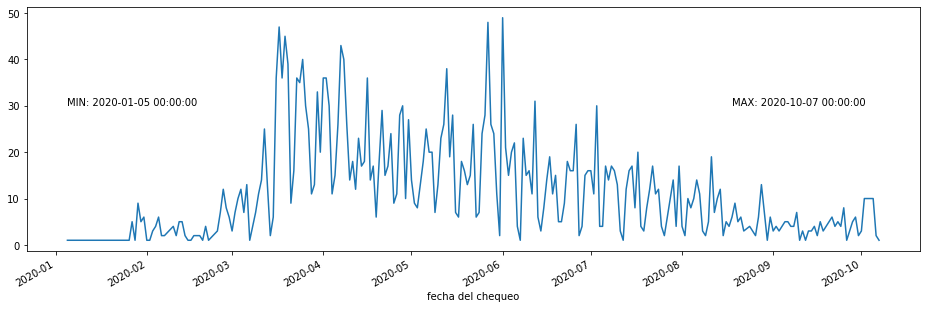

In [1150]:
df_cheq.groupby('fecha del chequeo').count()['pais'].plot(figsize=(16, 5))
plt.text(x=df_cheq['fecha del chequeo'].min(), 
         y=30, s=f"MIN: {df_cheq['fecha del chequeo'].min()}", rotation=0);
plt.text(x=df_cheq['fecha del chequeo'].max()-np.timedelta64(50, 'D'), 
         y=30, s=f"MAX: {df_cheq['fecha del chequeo'].max()}", rotation=0);

# CNN

In [1151]:
data = 'https://raw.githubusercontent.com/christianvadillo/InfoVac/main/data/raw/cnn_articles.csv'
df_cnn = pd.read_csv(data, encoding='latin-1', na_values=' ')
df_cnn

,id,url,author,date,description,sitename,title,text,categoria
0,1,https://cnnespanol.cnn.com/2020/03/16/coronavirus-16-de-marzo-las-muertes-por-coronavirus-superan-las-6-000-en-todo-el-mundo/,CNNEspa\u00f1ol Sebasti\u00e1n Jim\u00e9nez Valencia,2020-03-16,"Aumenta el número de muertos a más de 7.100 personas en todo el mundo, según un cálculo de la Universidad John Hopkins, que rastrea los casos repo...",CNN,Coronavirus 16 de marzo: 87 muertes por coronavirus en EE.UU. | CNN,"Aumenta el número de muertos: el nuevo coronavirus ha matado a más de 7.100 personas en todo el mundo, según un cálculo de la Universidad John Hop...",confiable
1,2,https://cnnespanol.cnn.com/2020/03/18/como-mata-el-coronavirus/,CNNEspa\u00f1ol Sebasti\u00e1n Jim\u00e9nez Valencia,2020-03-18,Lo que hace el virus es secuestrar las células sanas y reprogramarlas para que haga más copias del virus y así comienza a expandirse la infección....,CNN,¿Cómo mata el coronavirus? | CNN,"¿Cómo mata el coronavirus?\n(CNN Español)  Sabemos de los síntomas leves del coronavirus: el dolor de cabeza y de garganta, el malestar y la tos....",confiable
2,3,https://cnnespanol.cnn.com/2020/07/30/muere-herman-cain-por-coronavirus/,Paula Bravo Medina,2020-07-30,"Herman Cain, el ex candidato presidencial y ex presidente ejecutivo de Godfathers Pizza, murió de coronavirus, según un obituario enviado desde s...",CNN,Muere Herman Cain por coronavirus | CNN,"Muere Herman Cain por coronavirus\n(CNN)  Herman Cain, el ex candidato presidencial y ex presidente ejecutivo de Godfathers Pizza, murió de coro...",confiable
3,4,https://cnnespanol.cnn.com/2020/02/28/confirman-el-primer-caso-de-coronavirus-en-mexico/,Paula Bravo Medina,2020-02-28,"El Gobierno de México anunció este viernes los primeros casos de coronavirus en el país. Es el segundo, tercer y cuarto casos en América Latina de...",CNN,El coronavirus llega a México | CNN,"El coronavirus llega a México\n(CNN Español)  El Gobierno de México confirmó este viernes el primer caso de coronavirus en el país. Más adelante,...",confiable
4,5,https://cnnespanol.cnn.com/2020/05/15/opinion-lecciones-magistrales-del-coronavirus/,Juan Andr\u00e9s Mu\u00f1oz,2020-05-15,"El profesor Rafael Domingo Oslé presenta 10 cosas que nos ha enseñado esta crisis. | CNN Radio Argentina, Opinión | CNN",CNN,10 lecciones magistrales del coronavirus | CNN,10 lecciones magistrales del coronavirus\nNota del editor: Rafael Domingo Oslé es profesor en el Centro de Derecho y Religión de la Universidad de...,confiable
...,...,...,...,...,...,...,...,...,...
3727,3938,https://cnnespanol.cnn.com/2020/05/15/opinion-los-restaurantes-necesitaran-un-milagro-para-sobrevivir-a-esto/,Juan Andr\u00e9s Mu\u00f1oz,2020-05-15,"Sin acceso a las mismas opciones de financiación que las grandes cadenas corporativas, los propietarios de restaurantes como yo tienen que decidir...",CNN,OPINIÓN | Los restaurantes necesitarán un milagro para sobrevivir a esto | CNN,"(CNN)  Los restaurantes, especialmente los independientes, han sido diezmados por la pandemia. Sin acceso a las mismas opciones de financiación q...",confiable
3728,3939,https://cnnespanol.cnn.com/2020/06/10/esta-exastronauta-se-convierte-en-la-primera-persona-en-visitar-tanto-el-espacio-como-el-lugar-mas-profundo-...,Paula Bravo Medina,2020-06-10,"Solo ocho personas han llegado al Challenger Deep, el punto más profundo del océano. Más de 550 personas han visitado el espacio. Pero solo una pe...",CNN,Esta exastronauta es la primera persona que visita tanto el espacio como el lugar más profundo del océano | CNN,"Los aciertos y desaciertos en la historia de SpaceX 3:20\n(CNN)  Solo ocho personas han llegado al Challenger Deep, el punto más profundo del océ...",confiable
3729,3940,https://cnnespanol.cnn.com/2020/08/18/desnudos-mojigatos-y-swingers-el-hotel-hedonism-ii-se-adapta-a-la-era-de-la-pandemia/,\u00c1ngela Reyes,2020-08-18,"El hotel Hedonism II es un imán para nudistas, swingers y quienes buscan unas vacaciones al so

In [1152]:
df_cnn = df_cnn.convert_dtypes()

## Duplicados? 

In [1153]:
df_cnn['title'].duplicated().sum()

203

In [1154]:
df_cnn.drop_duplicates('title', keep='first', inplace=True)

In [1155]:
df_cnn['title'].duplicated().sum()

0

## Datos faltantes?

In [1156]:
df_cnn.isnull().sum()

id              0
url             0
author         74
date            2
description     0
sitename        0
title           0
text            0
categoria       0
dtype: int64

In [1157]:
df_cnn['author'].fillna('CNN', inplace=True)
df_cnn['date'].fillna('2020-03-16', inplace=True)

In [1158]:
df_cnn.isnull().sum()

id             0
url            0
author         0
date           0
description    0
sitename       0
title          0
text           0
categoria      0
dtype: int64

##Noticias no relacionadas?

In [1159]:
def out_of_context(row):
  title, text = row['title'], row['text']
  words = ['covid', 'coronavirus', 'vacuna', 'virus',
           'pandemia', 'sars-cov', 'cuarentena', 'infectado',
           'salud', 'oms', 'hospital', 'medico', 'dioxido', 'cloro', 
           'termometro', 'infrarojo', 
           'asinto', 'pcr', 'mascar', 'tapaboca', 'cubreboca', 'oximetro',
           'respira', 'contagi', 'desinfecta', 'dieta']
  for w in words:
    if (w in unidecode(text).lower()) or (w in unidecode(title).lower()):
      return False
  return True


In [1160]:
df_cnn['out_of_context'] = df_cnn.apply(lambda row: out_of_context(row), axis=1)
df_cnn['out_of_context'].sum()

55

In [1161]:
for title in df_cnn[df_cnn['out_of_context']]['title']:
  print(title)

Mirador Mundial: últimas noticias de Mirador Mundial  CNN
Gobierno de Colombia designa a Hezbollah como grupo terrorista y retira a las FARC de la lista | CNN
Confiscan US$ 900.000 en dinero falsificado: todo en billetes de US$ 1 | CNN
Estas fundas para el celular son ecológicas | CNN
GloboTemperatura: "La Fed procura no ser protagonista en 2020" | CNN
Ha sido realmente difícil: Taylor Swift revela que su mamá tiene un tumor en el cerebro | CNN
El doctor Anthony Fauci fue operado por un pólipo en las cuerdas vocales | CNN
Federer y Nadal baten el récord de asistencia en el tenis | CNN
Los primeros pasos Del Potro a 48 horas de una cirugía de rodilla | CNN
Se desploman las acciones | CNN
Maduro pide que una comisión de la ONU acompañe el proceso electoral parlamentario | CNN
Jorge Macri pide "poner un manto de paciencia" | CNN
Hay nuevos emoji con diseños más inclusivos de género y un popular gesto italiano con la mano | CNN
Alicia Keys rinde poderoso homenaje a Kobe Bryant en los Gr

Eliminando noticias no relacionadas

In [1162]:
df_cnn = df_cnn[~df_cnn['out_of_context']]

## Removiendo frases relacionadas a CNN

Explorando se encontró que en el título de ciertas noticias aparece la abreviatura CNN.


> *Muere Herman Cain por coronavirus | CNN*



In [1163]:
pd.options.display.max_colwidth = 150

In [1164]:
df_cnn[df_cnn['title'].apply(lambda x: 'cnn' in x.lower())]['title']

0                                                   Coronavirus 16 de marzo: 87 muertes por coronavirus en EE.UU. | CNN
1                                                                                      ¿Cómo mata el coronavirus? | CNN
2                                                                               Muere Herman Cain por coronavirus | CNN
3                                                                                   El coronavirus llega a México | CNN
4                                                                        10 lecciones magistrales del coronavirus | CNN
                                                             ...                                                       
3610    Esta exastronauta es la primera persona que visita tanto el espacio como el lugar más profundo del océano | CNN
3611                       Desnudos, mojigatos y swingers. El hotel Hedonism II se adapta a la era de la pandemia | CNN
3612                                    

También en el texto de los artículos provenientes de la fuente CNN, se encuentra sus abreviaturas. Siguen una estructura formada por:
> título ... (CNN) : texto...

Por ejemplo: 

> *Científicos dicen que un nuevo virus relacionado con el SARS es el culpable del misterioso brote de neumonía en China\n(CNN)  Según científicos c...*

In [1165]:
df_cnn[df_cnn['text'].apply(lambda x: 'cnn' in str(x).lower())]['text']

1       ¿Cómo mata el coronavirus?
(CNN Español)  Sabemos de los síntomas leves del coronavirus: el dolor de cabeza y de garganta, el malestar y la tos.
...
2       Muere Herman Cain por coronavirus
(CNN)  Herman Cain, el ex candidato presidencial y ex presidente ejecutivo de Godfathers Pizza, murió de coron...
3       El coronavirus llega a México
(CNN Español)  El Gobierno de México confirmó este viernes el primer caso de coronavirus en el país. Más adelante, ...
4       10 lecciones magistrales del coronavirus
Nota del editor: Rafael Domingo Oslé es profesor en el Centro de Derecho y Religión de la Universidad de ...
5       OPINIÓN | Elecciones infectadas con coronavirus
Nota del Editor: Patricio Morelos es consultor de comunicación política. Politólogo por el ITESM y...
                                                                                ...                                                                          
3609    OPINIÓN | Los restaurantes necesitarán un mi

In [1166]:
import re 
remove_list = ["Minuto a minuto", "panorama mundial:",  "cosas que debes saber",
                    "encuesta cnn:", "exclusiva de cnn:", "Ver más artículos de opinión sobre CNN", 
                    "CNN Español", "CNN Radio Argentina",  "\(CNN\)", "\| cnn",
                    "\#encuentrodigitalcnn",  "Ver más opinión en CNNe\.com\/opinion",
                    "CNN Radio", "nota del editor",  "OPINIÓN \|", "OPINIÓN:", "\[opinión\]", "\(opinión\)",
                    "ANÁLISIS:", "ANÁLISIS \|", "\(análisis\)",
                    "Lea más notas como esta en cnne\.com\/opinión", ]
remove_list = [word.lower() for word in remove_list]
exclusions = '(' + '|'.join(remove_list) + ')'

exclusions

'(minuto a minuto|panorama mundial:|cosas que debes saber|encuesta cnn:|exclusiva de cnn:|ver más artículos de opinión sobre cnn|cnn español|cnn radio argentina|\\(cnn\\)|\\| cnn|\\#encuentrodigitalcnn|ver más opinión en cnne\\.com\\/opinion|cnn radio|nota del editor|opinión \\||opinión:|\\[opinión\\]|\\(opinión\\)|análisis:|análisis \\||\\(análisis\\)|lea más notas como esta en cnne\\.com\\/opinión)'

In [1167]:
def remove_cnn_words(text):
  return re.sub(exclusions, '', text.lower(), flags=re.M)
    
df_cnn['text'] = df_cnn['text'].apply(remove_cnn_words)
df_cnn['title'] = df_cnn['title'].apply(remove_cnn_words)



In [1168]:
df_cnn[df_cnn['title'].apply(lambda x: 'cnn' in x.lower())]['title']

49                                                                                                   últimas noticias de panorama mundial  cnn
105                       coronavirus 14 de julio, : américa latina supera a ee.uu. y canadá en muertes por coronavirus, según análisis de cnn 
152                                                                                 ¿por qué cnn llama pandemia al nuevo brote de coronavirus? 
242                                                                        cnn en español estrena el podcast coronavirus: realidad vs. ficción 
288                                                                                cnn en español presenta el especial 'coronavirus: pandemia' 
381                                                            cnn en español lanza un podcast sobre el coronavirus con el doctor elmer huerta 
540                                      así es cómo la inteligencia artificial ha ayudado a luchar contra el coronavirus #encuentrocnnd

## Verificando la coherencia en 'date'

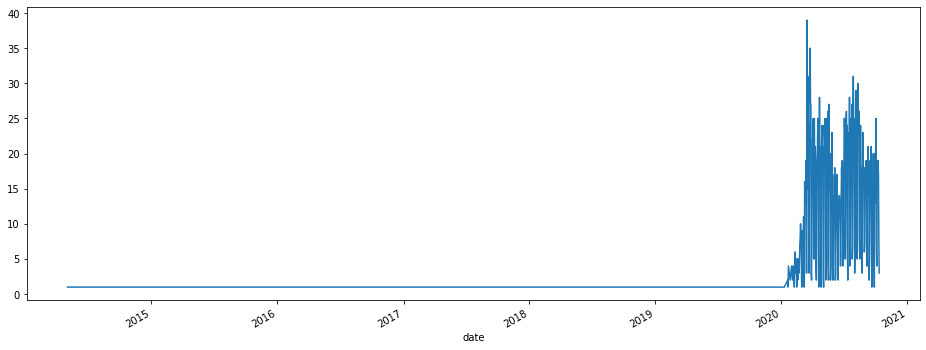

In [1169]:
df_cnn['date'] = pd.to_datetime(df_cnn['date'], yearfirst=True)
df_cnn.groupby('date').count()['title'].plot(figsize=(16, 6))

In [1170]:
to_drop = df_cnn['date'] < pd.to_datetime('2020/01/01')

In [1171]:
df_cnn = df_cnn[~to_drop]

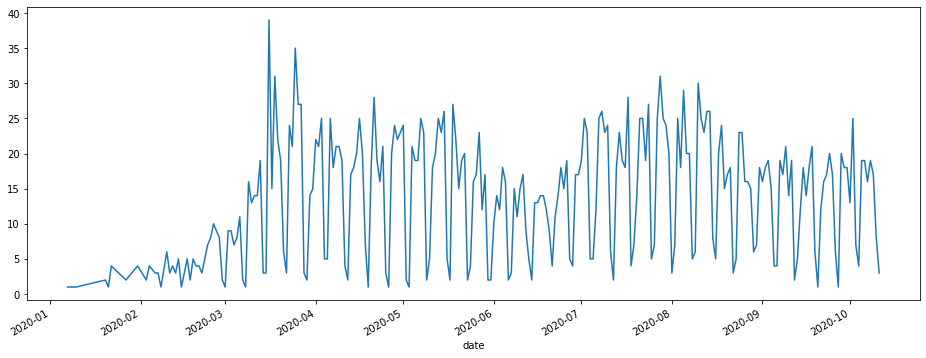

In [1172]:
df_cnn.groupby('date').count()['title'].plot(figsize=(16, 6))

# Unificando los conjuntos de datos

In [1173]:
df_google.columns.tolist()

['url',
 'reviewDate',
 'textualRating',
 'languageCode',
 'publisher.name',
 'publisher.site',
 'title',
 'text',
 'claimant',
 'claimDate',
 'out_of_context']

In [1174]:
df_cheq.columns.tolist()

['pais',
 'titulo',
 'calificacion',
 'descripcion',
 'fecha del chequeo',
 'organizacion',
 'link al chequeo',
 'tipo de informacion',
 'formato de la desinformacion',
 'tipo de nota',
 'link a la desinformacion',
 'fecha deteccion desinformacion',
 'origen',
 'persona',
 'actualizaciones',
 'circulo en otros paises',
 'extra']

In [1175]:
df_cnn.columns.tolist()

['id',
 'url',
 'author',
 'date',
 'description',
 'sitename',
 'title',
 'text',
 'categoria',
 'out_of_context']

In [1176]:
NORMALIZED_COLNAMES = {
      "url": ["url", "link al chequeo"],
      "titulo": ["title", "titulo"],
      "texto": ["text", "descripcion"],
      "categoria": ["textualRating", "calificacion"],
      # "fecha_revision": ["reviewDate", "fecha del chequeo"],
      "fecha_aparicion": ["reviewDate", "fecha del chequeo", 'date'],
      "organizacion": ["publisher.name", "organizacion", 'sitename']
      }

In [1177]:
def change_colnames(column):
  for k, v in NORMALIZED_COLNAMES.items():
    if column in v:
      return k
  return column

In [1178]:
[df.rename(columns=change_colnames, inplace=True) for df in [df_google, df_cheq, df_cnn]];

In [1179]:
columns = NORMALIZED_COLNAMES.keys()
df = pd.concat([df_google[columns].copy(), 
                df_cheq[columns].copy(),
                df_cnn[columns].copy()])


# Agrupando las categerías en 'confiable' y 'no confiable'

In [1180]:
from pprint import pprint

In [1181]:
categorias = set(df['categoria'])
pprint(sorted(categorias), width=40, compact=True)

['-', 'Apresurado ', 'Bulo ',
 'Chequeo Múltiple',
 'Chequeo múltiple ', 'Cierto ',
 'Cierto, pero ', 'Cuestionable',
 'Cuestionable ', 'Desvirtuado ',
 'Discurso falso', 'Discutible ',
 'Dudoso ', 'Engañoso', 'Engañoso ',
 'Exagerado ', 'Fake ', 'False',
 'Falseta ', 'Falso', 'Falso ', 'Faux',
 'Faux / Infondé', 'Fuera de contexto ',
 'Impreciso', 'Impreciso ',
 'Impreciso  ', 'Inchequeable ',
 'Inexacto-300x72', 'Insostenible',
 'Insostenible ', 'Manipulacja',
 'Manipulado ', 'Media Verdad',
 'Media verdad ', 'Mentira ', 'Montaje',
 'No es Fake ', 'No hay certeza ',
 'No hay evidencia',
 'No hay evidencia ',
 'No hay evidencias', 'No verificable ',
 'Parcialmente falso',
 'Parcialmente falso ',
 'Sacado de contexto ', 'Sesat',
 'Sin datos ', 'Sátira ', 'Verdad',
 'Verdad ', 'Verdadero', 'Verdadero ',
 'Verdadero pero...',
 'Verdadero, pero ', 'Verificamos',
 'Verificamos/Engañoso', 'Virales ',
 'confiable', 'distorcido', 'falso']


In [1182]:
confiable = ['Cierto ', 'Cierto, pero ', 'No es Fake ', 'Verdad', 'Verdad ',
             'Verdadero', 'Verdadero ', 'Verdadero pero...', 'Verdadero, pero ',
             'Verificamos', 'confiable']
             
no_confiable = categorias.difference(confiable)

In [1183]:
#Transformando los datos
df['cat'] = df['categoria'].apply(lambda x: 'confiable' if x in confiable else 'no confiable')

In [1184]:
df['cat'].value_counts()

confiable       4189
no confiable    3313
Name: cat, dtype: int64

In [1185]:
df.query("cat == 'no confiable'")['categoria'].value_counts()

Falso                   1628
Falso                    731
Bulo                     300
Engañoso                 166
Engañoso                 109
Falseta                   85
falso                     42
Cuestionable              42
Sacado de contexto        31
Cuestionable              28
Chequeo múltiple          19
-                         17
Insostenible              12
Mentira                   11
Chequeo Múltiple           8
Media verdad               7
Fuera de contexto          6
Manipulado                 6
Impreciso                  6
Fake                       5
Impreciso                  5
Discutible                 4
Parcialmente falso         4
Parcialmente falso         4
Impreciso                  3
False                      3
No hay certeza             3
Apresurado                 3
Sátira                     2
Faux                       2
No hay evidencia           2
No hay evidencia           1
Manipulacja                1
Sin datos                  1
Virales       

In [1186]:
df.query("cat == 'confiable'")['categoria'].value_counts()

confiable            4071
Verdadero              51
Verdadero, pero        20
Verdadero pero...      13
Verdadero              13
Verificamos             8
Cierto                  5
Verdad                  3
No es Fake              2
Verdad                  2
Cierto, pero            1
Name: categoria, dtype: Int64

## Duplicados?

In [1187]:
df['texto'].value_counts()

no text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [1188]:
# Llenando textos faltantes
df.loc[df['texto'] == 'no text', 'texto'] =\
  df.loc[df['texto'] == 'no text', 'titulo']

df['texto'].fillna(df['titulo'], inplace=True)

In [1189]:
# Eliminando duplicados
df.drop_duplicates('texto', inplace=True)

In [1194]:
df['texto'].duplicated().sum()

0

# Guardar el dataset final v 0.1

In [1190]:
df.head()

,url,titulo,texto,categoria,fecha_aparicion,organizacion,cat
0,https://www.newtral.es/bulos-coronavirus-pcr-kary-mullis-videos/20201013/,no title,"Estos vídeos de Kary Mullis, inventor del PCR, dejan muy claro que el test no sirve para detectar virus. Desmontan la herramienta que usan nuestro...",Falso,2020-10-13 00:00:00+00:00,Newtral,no confiable
1,https://colombiacheck.com/chequeos/no-ecuador-no-encontro-la-cura-para-el-covid-19-ni-mando-al-carajo-la-oms,"No, Ecuador no encontró la cura para el COVID-19 ni ‘mandó al carajo a la OMS’",Ecuador venció al coronavirus,Falso,2020-10-08 18:36:17+00:00,ColombiaCheck,no confiable
2,https://www.telemundo.com/noticias/noticias-telemundo/elecciones-eeuu-2020/las-afirmaciones-falsas-y-enganosas-que-verificamos-durante-el-debate-e...,Las afirmaciones falsas y engañosas del debate entre Harris y Pence,"""Trump llamó al coronavirus un ""fraude"".",Falso,2020-10-08 00:00:00+00:00,Telemundo,no confiable
3,https://factual.afp.com/la-inscripcion-en-cajas-de-tapabocas-no-prueba-que-sean-inutiles-para-frenar-la-propagacion-de-covid,La inscripción en cajas de tapabocas no prueba que sean inútiles para frenar la propagación de covid-19,La inscripción en las cajas de mascarillas prueban que estas no sirven contra el nuevo coronavirus,Falso,2020-10-07 18:36:00+00:00,AFP Factual,no confiable
4,https://chequeado.com/ultimas-noticias/alesso-ctera-en-los-lugares-donde-hay-pocos-casos-de-coronavirus-hay-clases/,"Alesso (CTERA): “En los lugares donde hay pocos casos, hay clases”","En los lugares donde hay pocos casos de coronavirus, hay clases",Falso,2020-10-07 00:00:00+00:00,Chequeado,no confiable


In [1191]:
df.to_csv('covid_fakenews_es')

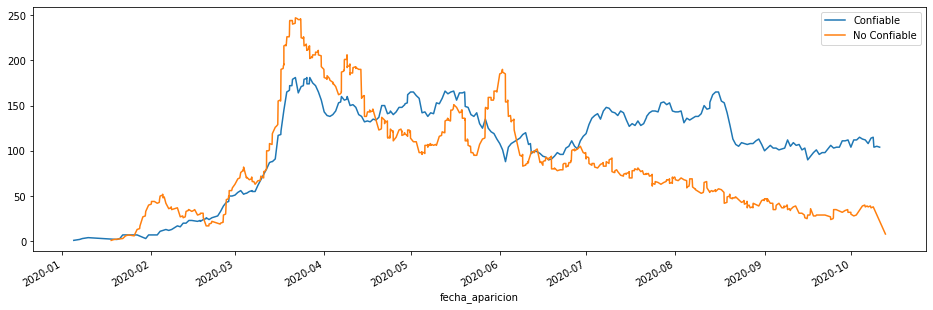

In [1192]:
df = pd.read_csv('covid_fakenews_es')
df['fecha_aparicion'] = pd.to_datetime(df['fecha_aparicion'], utc=True)
df.sort_values(by='fecha_aparicion', inplace=True, ignore_index=True)
conf = df.query("cat == 'confiable'")
no_conf = df.query("cat == 'no confiable'")

conf.groupby(['fecha_aparicion']).count()['cat'].rolling('7d').sum().plot(figsize=(16,5), label='Confiable')
no_conf.groupby(['fecha_aparicion']).count()['cat'].rolling('7d').sum().plot(figsize=(16,5), label = 'No Confiable')
plt.legend()